<a href="https://colab.research.google.com/github/Junying123/food-vision-pytorch/blob/main/Food_Vision_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# setup torch
try:
  import torch
  print(f"torch version: {torch.__version__}")
except:
  %pip install torch
  import torch
  print(f"torch version: {torch.__version__}")


In [ ]:
pip install torchinfo

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    # This assumes that the going_modular directory is in the root directory of your Colab environment
    from going_modular import data_setup, engine
except ModuleNotFoundError:
    # If not found, download the going_modular scripts from GitHub
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/Junying123/food-vision-pytorch.git
    # Note: In the original code, the 'mv' command was missing a destination.
    # It should move the directory to the current directory, denoted by '.'
    !mv food-vision-pytorch/going_modular .
    !rm -rf food-vision-pytorch
    # Append the path to sys.path
    import sys
    sys.path.append('/content/going_modular')
    # After updating the sys.path we can attempt the import again
    from going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:

import requests
import zipfile
from pathlib import Path
import os

# setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# download pizza, steak and sushi
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/Junying123/branching/raw/main/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

In [ ]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2.Create Datasets and DataLoaders

## 2.1 Creating a transform for torchvision.models (manual creation)

In [ ]:
# Create a transforms pipeline
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=data_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

## 2.2 Creating a transform for torchvision.models (auto creation)

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

# 3.Getting a pretrained model

## 3.2 Setting up a pretrained model

In [ ]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

## 3.3 Getting a summary of our model

- features: A collection of convolutional layers and activation layers to learn a base representation of vision data
- avgpool: Takes the average of the output of the features layer(s) and converts it into a feature vector
- classifier: Transforms the feature vector into a vector with the same dimensionality as the number of required output classes (default is 1000 for efficientnet_b0 pretrained on ImageNet)

- model - the model for which we want to generate a summary.
- input_size - the dimensions of the input data for our model. For efficientnet_b0, the input size is (batch_size, 3, 224, 224), but other variants of efficientnet_bX may have different input sizes.
- col_names - the specific columns of information want to include in the model summary.
- col_width - the desired width of the columns in the summary.
row_settings - the features to display in each row of the summary.

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

## 3.4 Freezing the base model and changing the output layer

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # 3 classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

- Base layers have Trainable set as False, so they won't be updated during future training unless changed
- The classifier now has an Output Shape of [32, 3] instead of [32, 1000], with Trainable set as True for parameter updates during training
- Freezing many layers resulted in only 3,843 trainable parameters, creating a base representation for input images to feed into the classifier layer

# 4.Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 200.809 seconds


# 5.Evaluate model by plotting loss curves

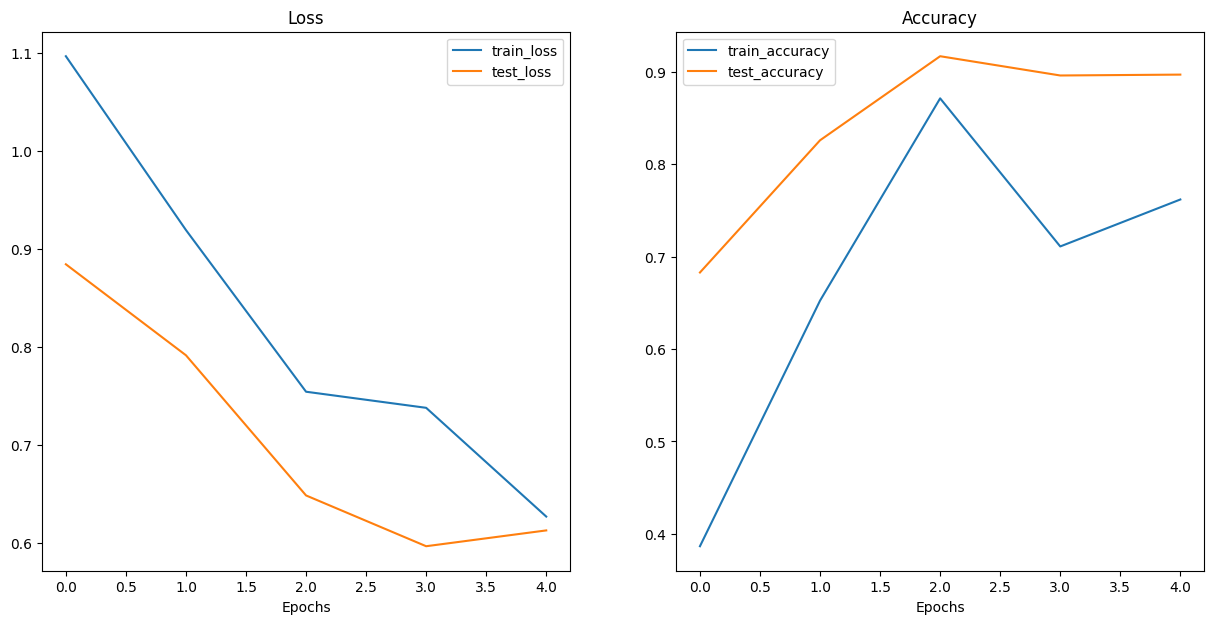

In [ ]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# 6.Make predictions on images from the test set

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

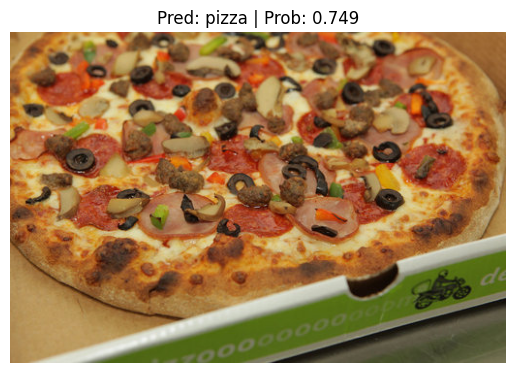

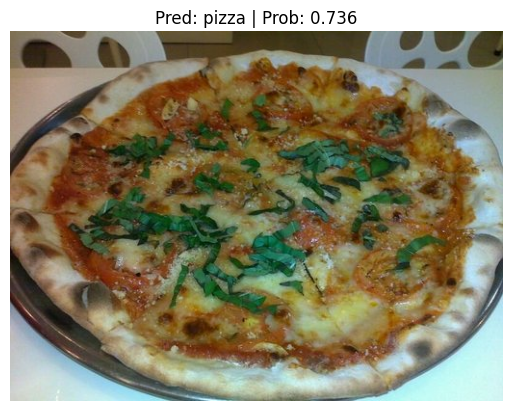

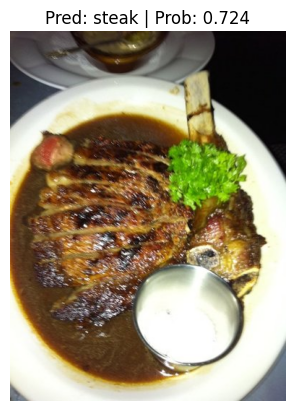

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(),
                        image_size=(224, 224))

data/images.jpeg already exists, skipping download.


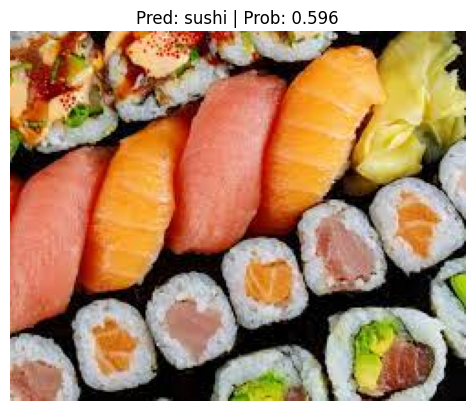

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "images.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/Junying123/branching/main/images.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# 7.Make predictions on the entire test dataset with the model

In [ ]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [ ]:
len(class_names)

3

In [ ]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

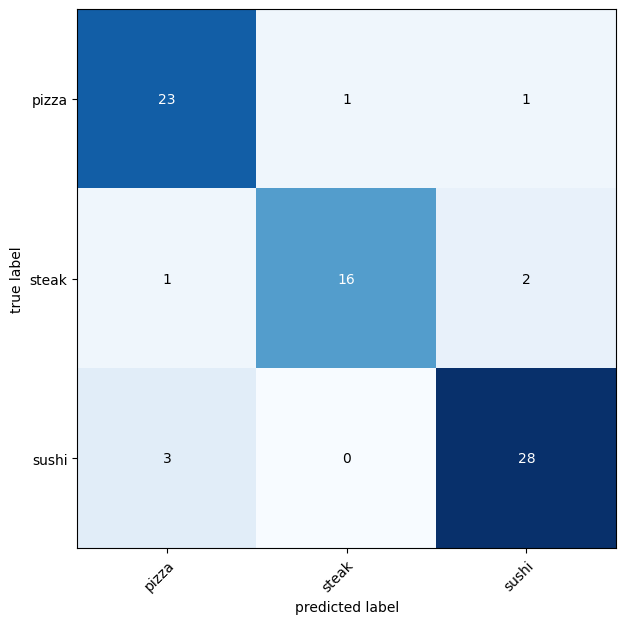

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


# Setup the confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=test_preds, target=test_truth)


# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

# Get the  5 most most wrong of the predictions on the test dataset

In [ ]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

In [ ]:
test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=data_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5717651844024658,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5573277473449707,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.47809743881225586,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.46345454454421997,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.44235244393348694,
  'pred_class': 'sushi',
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
12   data/pizza_steak_sushi/test/sushi/684266.jpg      sushi   0.517367   
3   data/pizza_steak_sushi/test/sushi/2394442.jpg      sushi   0.463455   
45    data/pizza_steak_sushi/test/steak/27415.jpg      steak   0.449256   
53  data/pizza_steak_sushi/test/pizza/2871261.jpg      pizza   0.432400   
17  data/pizza_steak_sushi/test/sushi/1230335.jpg      sushi   0.426783   

   pred_class  correct  
12      steak    False  
3       pizza    False  
45      sushi    False  
53      steak    False  
17      pizza    False

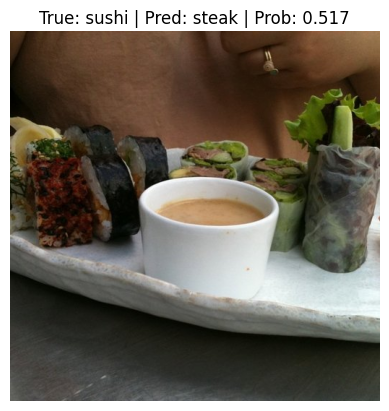

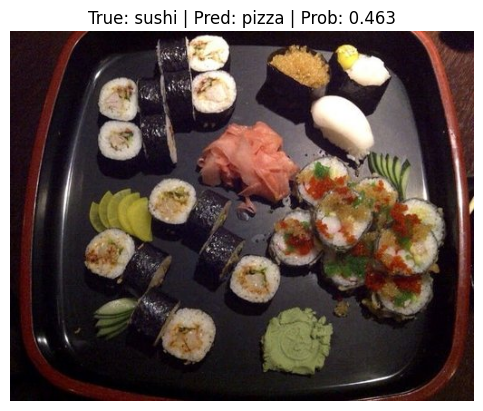

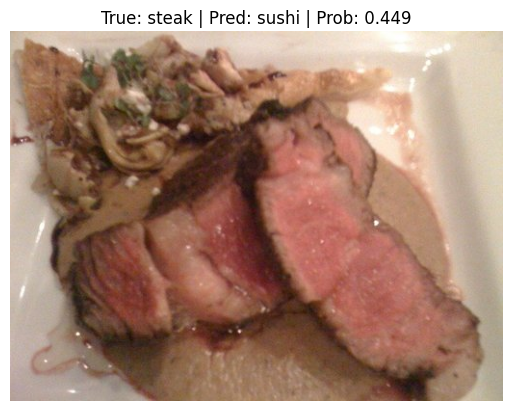

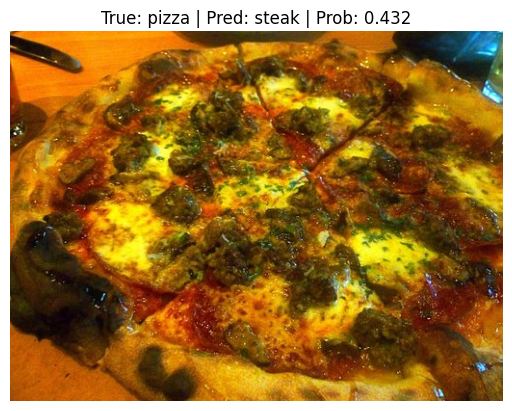

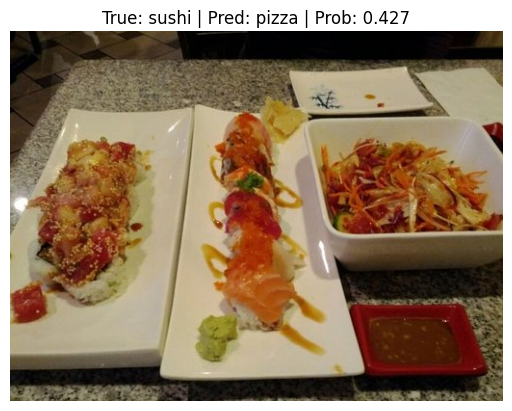

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

--2024-04-01 11:36:39--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a.2’

photo-1588315029754 100%[===================>]   3.06M  --.-KB/s    in 0.07s   

2024-04-01 11:36:40 (46.0 MB/s) - ‘photo-1588315029754-2dd089d39a1a.2’ saved [3208960/3208960]



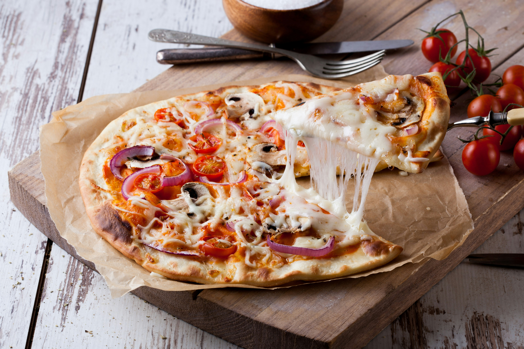

In [ ]:
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

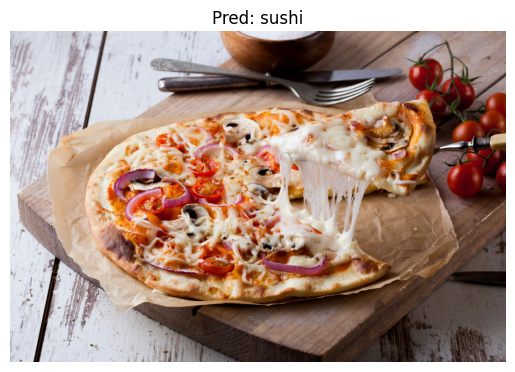

In [ ]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

  # plot image and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model,
              transform=data_transform,
              class_names=class_names)

--2024-04-01 11:36:45--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617320 (3.4M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef.4’

photo-1546964124-0c 100%[===================>]   3.45M  --.-KB/s    in 0.07s   

2024-04-01 11:36:45 (46.9 MB/s) - ‘photo-1546964124-0cce460f38ef.4’ saved [3617320/3617320]



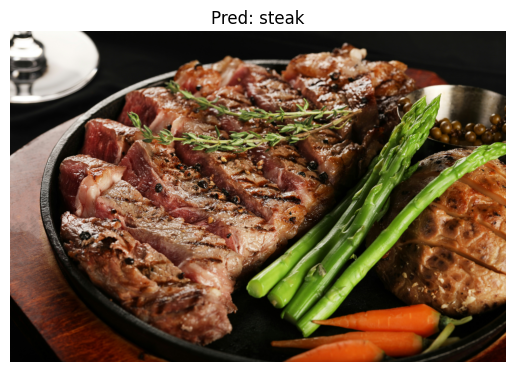

In [ ]:
# Try again on a photo of steak from unsplash.com
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model,
              transform=data_transform,
              class_names=class_names)

--2024-04-01 11:36:54--  https://images.unsplash.com/photo-1553621042-f6e147245754
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2890292 (2.8M) [image/jpeg]
Saving to: ‘photo-1553621042-f6e147245754.2’

photo-1553621042-f6 100%[===================>]   2.76M  --.-KB/s    in 0.1s    

2024-04-01 11:36:54 (25.9 MB/s) - ‘photo-1553621042-f6e147245754.2’ saved [2890292/2890292]



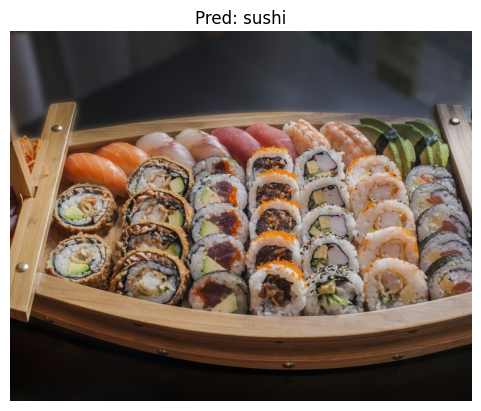

In [ ]:
# Try again on a photo of sushi from unsplash.com
!wget https://images.unsplash.com/photo-1553621042-f6e147245754
!cp photo-1553621042-f6e147245754 sushi.jpg

pred_and_plot("sushi.jpg",
              model=model,
              transform=data_transform,
              class_names=class_names)

--2024-04-01 11:37:03--  https://images.unsplash.com/photo-1544982503-9f984c14501a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1468014 (1.4M) [image/jpeg]
Saving to: ‘photo-1544982503-9f984c14501a.2’

photo-1544982503-9f 100%[===================>]   1.40M  6.52MB/s    in 0.2s    

2024-04-01 11:37:03 (6.52 MB/s) - ‘photo-1544982503-9f984c14501a.2’ saved [1468014/1468014]



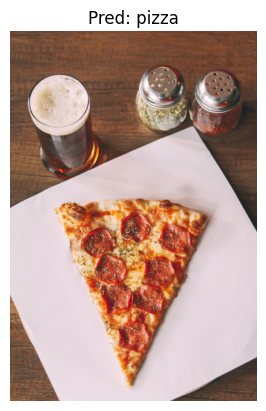

In [ ]:
# Try again on a photo of sushi from unsplash.com
!wget https://images.unsplash.com/photo-1544982503-9f984c14501a
!cp photo-1544982503-9f984c14501a pizza_1.jpg

pred_and_plot("pizza_1.jpg",
              model=model,
              transform=data_transform,
              class_names=class_names)

# Train a model with 20% of the data

In [ ]:
# Get random 20% of training images
import random

# Setup data directory
import pathlib
data_dir = pathlib.Path("../data")

import torchvision.datasets as datasets
# Get training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              # transform=transforms.ToTensor(),
                              download=True)

# Get testing data
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             # transform=transforms.ToTensor(),
                             download=True)


# Setup data paths
data_path = data_dir / "food-101" / "images"
target_classes = ["pizza", "steak", "sushi"]

In [ ]:
amount_to_get = 0.2

# Create function to separate a random amount of data
def get_subset(image_path=data_path,
               data_splits=["train", "test"],
               target_classes=["pizza", "steak", "sushi"],
               amount=0.1,
               seed=42):
    random.seed(42)
    label_splits = {}

    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)

        # Apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits

label_splits = get_subset(amount=amount_to_get)
label_splits["train"][:10]

[INFO] Creating image split for: train...
[INFO] Getting random subset of 450 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 150 images for test...


[PosixPath('../data/food-101/images/pizza/3269634.jpg'),
 PosixPath('../data/food-101/images/pizza/1524655.jpg'),
 PosixPath('../data/food-101/images/steak/2825100.jpg'),
 PosixPath('../data/food-101/images/steak/225990.jpg'),
 PosixPath('../data/food-101/images/steak/1839481.jpg'),
 PosixPath('../data/food-101/images/pizza/38349.jpg'),
 PosixPath('../data/food-101/images/pizza/3018077.jpg'),
 PosixPath('../data/food-101/images/sushi/93139.jpg'),
 PosixPath('../data/food-101/images/pizza/2702825.jpg'),
 PosixPath('../data/food-101/images/sushi/200025.jpg')]

In [ ]:
# Create target directory path
target_dir_name = f"../data/pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: '../data/pizza_steak_sushi_20_percent'


In [ ]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

[INFO] Copying ../data/food-101/images/pizza/3269634.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/3269634.jpg...
[INFO] Copying ../data/food-101/images/pizza/1524655.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/1524655.jpg...
[INFO] Copying ../data/food-101/images/steak/2825100.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/2825100.jpg...
[INFO] Copying ../data/food-101/images/steak/225990.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/225990.jpg...
[INFO] Copying ../data/food-101/images/steak/1839481.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/1839481.jpg...
[INFO] Copying ../data/food-101/images/pizza/38349.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/38349.jpg...
[INFO] Copying ../data/food-101/images/pizza/3018077.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/3018077.jpg...
[INFO] Copying ../data/food-101/images/sushi/93139.jpg to ../data/pizza_steak_sushi_20_percent/train/sushi/93139.jpg...
[INFO] Copying ../

In [ ]:
zip_file_name = data_dir / f"pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
shutil.make_archive(zip_file_name,
                    format="zip",
                    root_dir=target_dir)

'/data/pizza_steak_sushi_20_percent.zip'

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/Junying123/food-vision-pytorch/raw/main/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

data/pizza_steak_sushi_20_percent directory exists.


In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=data_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d3b46b9ba60>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
len(train_dataloader_20_percent), len(test_dataloader_20_percent)

(15, 5)

In [ ]:
# Create a new model for 20 percent of the data
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9913 | train_acc: 0.5521 | test_loss: 0.6565 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.7156 | train_acc: 0.7937 | test_loss: 0.5414 | test_acc: 0.8943
Epoch: 3 | train_loss: 0.5648 | train_acc: 0.8521 | test_loss: 0.4511 | test_acc: 0.9006
Epoch: 4 | train_loss: 0.4661 | train_acc: 0.9042 | test_loss: 0.4053 | test_acc: 0.8915
Epoch: 5 | train_loss: 0.4526 | train_acc: 0.8708 | test_loss: 0.3743 | test_acc: 0.9006
[INFO] Total training time: 377.710 seconds


In [ ]:
import pandas as pd
model_df = pd.DataFrame(model_2_results)
model_df

train_loss  train_acc  test_loss  test_acc
0    0.991313   0.552083   0.656546  0.891477
1    0.715619   0.793750   0.541397  0.894318
2    0.564757   0.852083   0.451133  0.900568
3    0.466133   0.904167   0.405252  0.891477
4    0.452604   0.870833   0.374313  0.900568

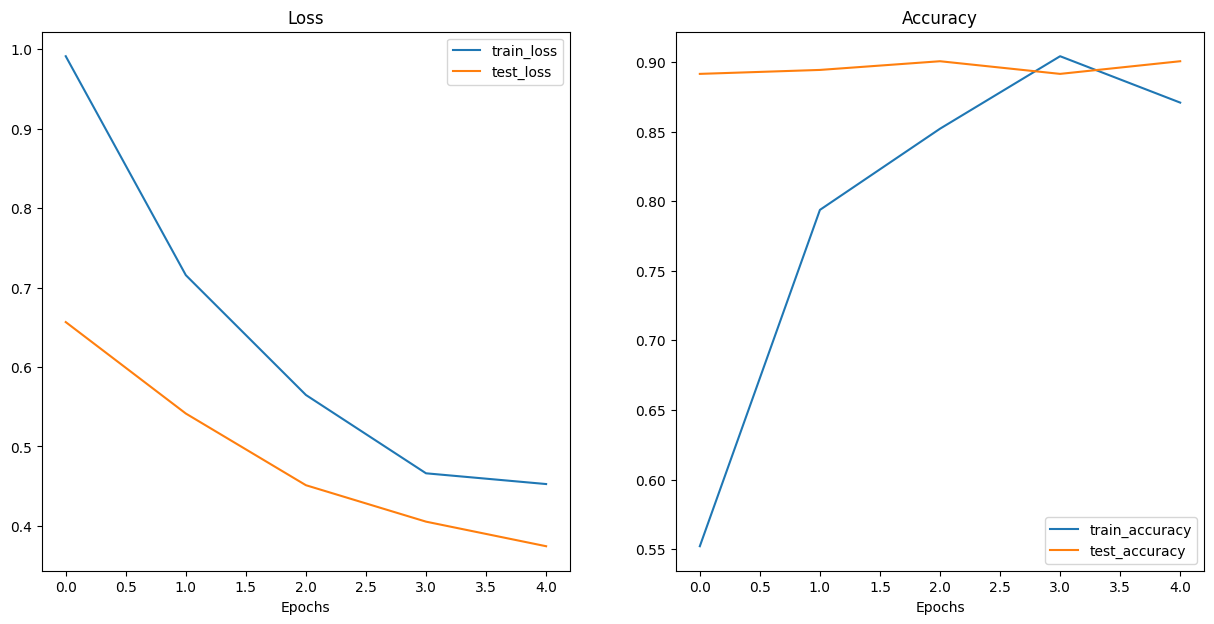

In [ ]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_2_results)

# 8.Try a different model from torchvision.models

In [ ]:
# Create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
  transforms.Resize((288, 288)), # effnet_b2 takes images of size 288, 288
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b2_transform,
                                                                                                   batch_size=32)

In [ ]:
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze the base layers
for param in model_3.parameters():
  param.requires_grad = False

# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b2,
                              test_dataloader=test_dataloader_effnet_b2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0900 | train_acc: 0.3516 | test_loss: 0.9310 | test_acc: 0.6515
Epoch: 2 | train_loss: 0.9053 | train_acc: 0.6172 | test_loss: 0.8682 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7341 | train_acc: 0.8906 | test_loss: 0.7510 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7788 | train_acc: 0.7305 | test_loss: 0.7130 | test_acc: 0.8059
Epoch: 5 | train_loss: 0.6698 | train_acc: 0.7773 | test_loss: 0.6619 | test_acc: 0.9280
[INFO] Total training time: 467.561 seconds


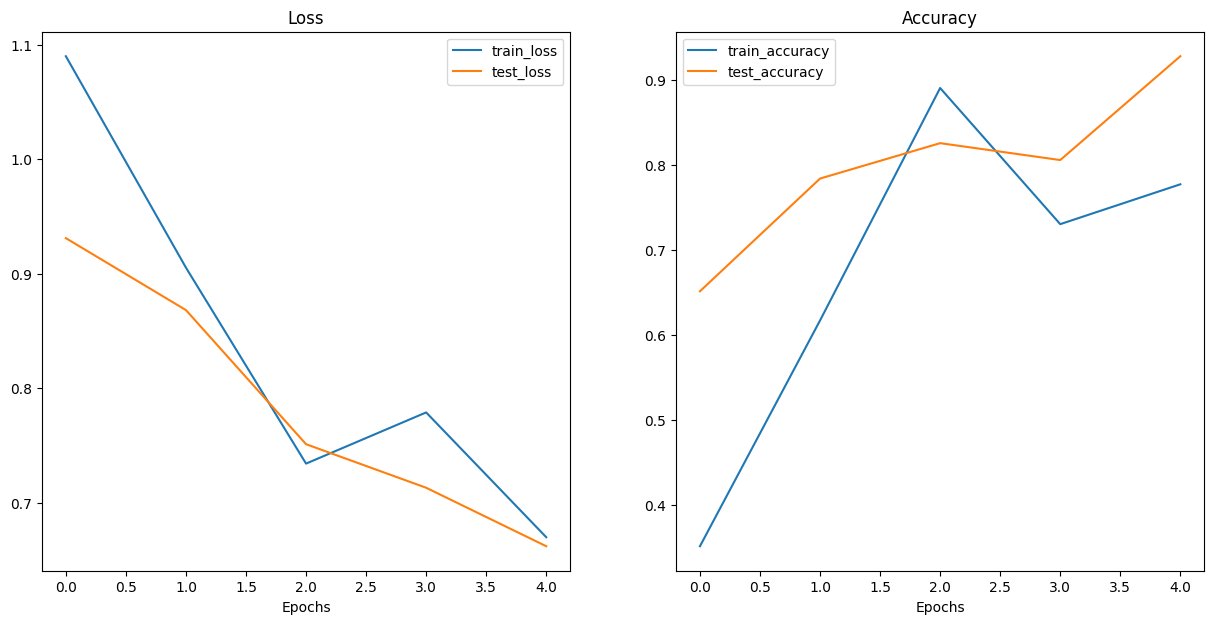

In [ ]:

# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_3_results)

# Train the model for longer 10 epochs

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5591 | train_acc: 0.9062 | test_loss: 0.5624 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.5287 | train_acc: 0.8125 | test_loss: 0.5471 | test_acc: 0.8362
Epoch: 3 | train_loss: 0.4379 | train_acc: 0.9375 | test_loss: 0.4634 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.4736 | train_acc: 0.8047 | test_loss: 0.4343 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.4321 | train_acc: 0.8242 | test_loss: 0.4677 | test_acc: 0.8258
Epoch: 6 | train_loss: 0.4268 | train_acc: 0.8320 | test_loss: 0.4298 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.4353 | train_acc: 0.8203 | test_loss: 0.4751 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.3864 | train_acc: 0.8320 | test_loss: 0.4037 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.3602 | train_acc: 0.9375 | test_loss: 0.4075 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4733 | train_acc: 0.7891 | test_loss: 0.4467 | test_acc: 0.8665
[INFO] Total training time: 369.006 seconds


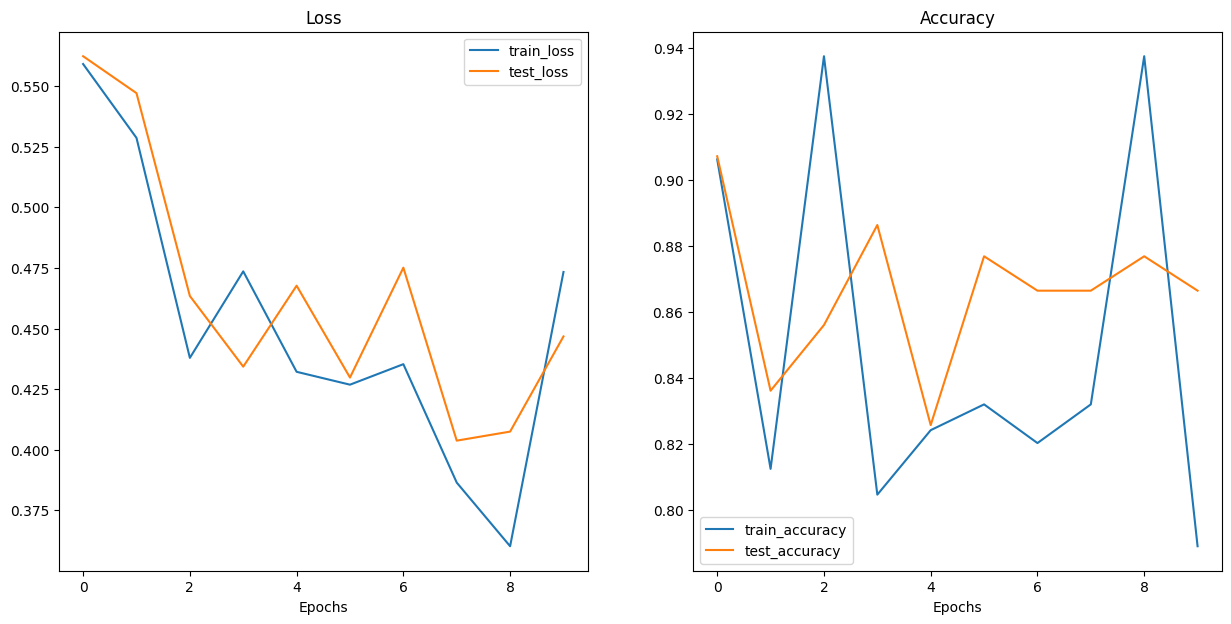

In [ ]:

# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)